Load data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/sleep_health_clean.csv', sep=';')

X = data.drop(columns=["Sleep Disorder"], inplace=False)
y = data["Sleep Disorder"].values.reshape(-1, 1)

Load pipelines

In [2]:
from sklearn.pipeline import Pipeline
import joblib

target_pipeline: Pipeline = joblib.load('data-pipelines-bin/target_pipeline')
predictor_pipeline: Pipeline = joblib.load('data-pipelines-bin/predictor_pipeline')

Transform data through pipelines

In [3]:
X = predictor_pipeline.transform(X)

In [4]:
y = target_pipeline.transform(y)

Split for final evaluation

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100, shuffle=True)

Find number of features

In [6]:
no_of_features = X.shape[1]

In [7]:
from keras_tuner import HyperParameters, GridSearch
from keras.models import Model
from keras.layers import Input,Dense
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.optimizers import Adam

Define model builder, used for hyperparameter tuning

In [8]:
def model_builder(hp: HyperParameters) -> Model:
    inputs = Input(shape=(no_of_features,), name='input', dtype=np.float32)
    units1 = hp.Int('units1', min_value=8, max_value=64, step=4)
    dense1 = Dense(units1,name='dense_1', activation='relu')(inputs)
    units2 = hp.Int('units2', min_value=4, max_value=32, step=2)
    dense2 = Dense(units2,name='dense_2', activation='relu')(dense1)
    output1 = Dense(3,name='output',activation='softmax')(dense2)
    model = Model(inputs = inputs, outputs = output1, name="sleep-health_classification")
    lr = hp.Float('learning_rate', min_value=1e-3,max_value=1e-2, step=1e-3)
    model.compile(loss=CategoricalCrossentropy(name='loss'),
                  optimizer=Adam(learning_rate=lr),
                  metrics=[CategoricalAccuracy(name='accuracy')]
                  )
    return model

Early stopping, prevents ovefitting when learning slows

In [9]:
early_stopping = EarlyStopping(monitor='loss',
                               min_delta=0.05,  # najmanja promena u odnosu na prethodnu epohu
                               patience=2,
                               # broj epoha sa promenom manjom od delta vrednosti nakon ceka trening staje
                               verbose=1,  # da prikaze zasto je trening zaustavljen
                               restore_best_weights=True)

Create tuner class

In [10]:
tuner = GridSearch(model_builder,objective='loss', seed=100)

Save checkpoints

In [11]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# 
# 
# checkpoint = ModelCheckpoint(
#     weights_format,
#     monitor='loss',  # loss je parametar treniranja
#     verbose=0,  # 1 da prikazuje svaki callback, ne treba
#     save_best_only=True,  # svaka iteracija pamti samo najbolje tezine
#     mode='min'  # ako treba da se overwrituje fajl, zapamti sa manjim lossom
# )

Search the grid for best hyperparameter combination

In [12]:
tuner.search(X_train,y_train,epochs = 50, callbacks=[early_stopping])

Trial 2250 Complete [00h 00m 01s]
loss: 0.30817821621894836

Best loss So Far: 0.2856726050376892
Total elapsed time: 00h 46m 07s
INFO:tensorflow:Oracle triggered exit


Get best hyperparameters and create hypermodel 

In [13]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
hypermodel: Model = tuner.hypermodel.build(best_hps)

Train hypermodel

In [15]:
history = hypermodel.fit(X_train, y_train, epochs=50, validation_split=0.2, shuffle = True,callbacks=[early_stopping], )


Epoch 1/50
8/8 [==============================] - 1s 29ms/step - loss: 0.8026 - accuracy: 0.6904 - val_loss: 0.6388 - val_accuracy: 0.7833
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4477 - accuracy: 0.8661 - val_loss: 0.5875 - val_accuracy: 0.9000
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.3630 - accuracy: 0.8954 - val_loss: 0.5578 - val_accuracy: 0.9000
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.3354 - accuracy: 0.8996 - val_loss: 0.5014 - val_accuracy: 0.9000
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.3082 - accuracy: 0.9121 - val_loss: 0.4738 - val_accuracy: 0.9000
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2850 - accuracy: 0.9331 - val_loss: 0.4707 - val_accuracy: 0.9000
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 0.2867 - accuracy: 0.9331 - val_loss: 0.5170 - val_accuracy: 0.9000
Epoch 7: early stopping


Evaluate

In [16]:
eval = hypermodel.evaluate(x=X_test,y=y_test)

3/3 [==============================] - 0s 887us/step - loss: 0.3900 - accuracy: 0.9333


In [17]:
eval

[0.39000728726387024, 0.9333333373069763]

In [18]:
len(history.history['loss'])

7

Save history to `history.csv`

In [19]:
history =  pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))

history.to_csv('results/history.csv', index=True, index_label = "Epoch")

Save evaluation to `evaluation.csv`

In [20]:
pd.DataFrame(data={'Test Loss': eval[0], 'Test Accuracy': eval[1]}, index=[1]).to_csv('results/evaluation.csv', index=False)

In [21]:
hypermodel.save(filepath='results/model.keras', overwrite=True)

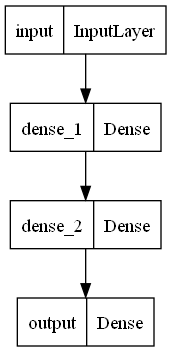

In [23]:
from keras.utils import plot_model

plot_model(hypermodel, to_file='model/model.png',  show_shapes=False,
           show_dtype=False,
           show_layer_names=True,
           show_layer_activations=False,
           show_trainable=False)